In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.model_selection as cv
import sklearn.feature_selection as feat
import sklearn.preprocessing as Pre
import sklearn.tree as Tree
import sklearn.ensemble as Ens
import sklearn.metrics as m

import warnings
warnings.filterwarnings('ignore')

# Meta-learning methods

In [2]:
data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',', na_values="NA").drop(columns='Id')

In [3]:
data.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,Fence,MiscVal,SaleType,SaleCondition,SalePrice,MasVnr,SecondFloor,Baths,Porch,Pool
0,G,RH,0.185945,1.0,Lvl,Inside,Edwards,Artery,1Fam,2Story,...,0.0,0.0,WD,Normal,Level2,0.0,1.0,0.4,True,0.0
1,A,RL,0.198890,1.0,Lvl,Inside,NAmes,Norm,1Fam,1Story,...,1.0,0.0,WD,Family,Level2,1.0,0.0,0.0,True,0.0
2,L,RL,0.260616,1.0,Lvl,Corner,NridgHt,Norm,Twnhs,1Story,...,0.0,0.0,New,Partial,Level4,1.0,0.0,0.4,True,0.0
3,A,RL,0.251230,1.0,Lvl,Inside,NAmes,Norm,1Fam,1Story,...,1.0,0.0,WD,Abnorml,Level1,1.0,0.0,0.0,False,0.0
4,E,RL,0.174186,1.0,Lvl,Inside,SWISU,Norm,1Fam,1.5Fin,...,0.0,0.0,WD,Normal,Level2,0.0,1.0,0.4,True,0.0


In [4]:
kfold = cv.StratifiedKFold(n_splits=10, random_state=1) 

In [5]:
X = data.drop(columns='SalePrice')
Y = data.loc[:,'SalePrice']

le = Pre.LabelEncoder()
le.fit(Y)
Y = le.fit_transform(Y)
i = 0
for t in X.dtypes:
    if t == object or t == bool:
        le.fit(X.iloc[:,i])
        X.iloc[:,i] = le.fit_transform(X.iloc[:,i])
    i += 1

X_train, X_test, y_train, y_test = cv.train_test_split(X, Y, test_size=.3, random_state=1)

In [6]:
datapca = pd.read_csv('../datasets/preprocessed/train_pca.csv', sep=',', na_values="NA").drop(columns='Id')

In [7]:
datapca.head()

,0,1,2,3,4,5
0,-0.753748,0.636941,-0.164025,-0.204247,0.549835,0.539191
1,-0.117306,-0.688384,-0.493263,0.796882,-0.008604,-0.239237
2,0.787114,-0.469485,-0.626444,-0.272131,-0.467151,0.305142
3,-0.172825,-0.708999,-0.480148,0.864432,0.145394,-0.106748
4,-0.488369,0.642514,-0.179286,-0.202405,0.023691,-0.091447


In [8]:
X_trainpca, X_testpca, y_trainpca, y_testpca = cv.train_test_split(datapca, Y, test_size=.3, random_state=1)

## Bagging

In [9]:
bg = Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(), random_state=0).fit(X_train, y_train)
bg.score(X_test,y_test)

0.804635761589404

In [10]:
cvs = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(), random_state=0),
                         X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.808148893360161

In [11]:
pred=bg.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 13  10   0   0   0]
 [  9 182   9   0   0]
 [  0  20  40   2   0]
 [  0   0   6   6   0]
 [  0   0   0   3   2]]
0.804635761589404
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        23
           1       0.86      0.91      0.88       200
           2       0.73      0.65      0.68        62
           3       0.55      0.50      0.52        12
           4       1.00      0.40      0.57         5

    accuracy                           0.80       302
   macro avg       0.74      0.60      0.65       302
weighted avg       0.80      0.80      0.80       302



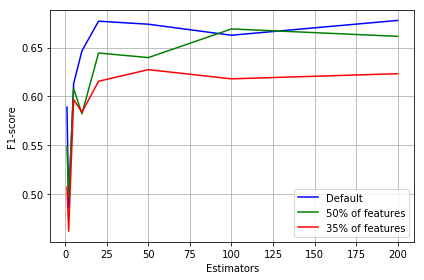

In [12]:
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                                                      n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                                                      n_estimators=nest,
                                                      max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                                                      n_estimators=nest,
                                                      max_features=0.5),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Default')
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='50% of features')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='35% of features')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

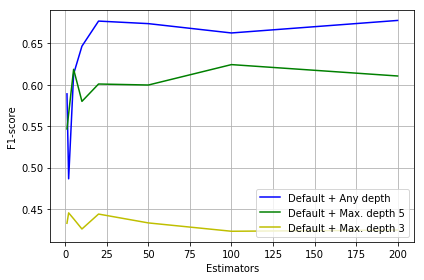

In [13]:
plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Default + Any depth')

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(max_depth=3),
                                                      n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb4=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(max_depth=5),
                                                      n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb4.append(scores.mean())



plt.plot([1,2,5,10,20,50,100,200],lb4,'g',label='Default + Max. depth 5')
plt.plot([1,2,5,10,20,50,100,200],lb,'y',label='Default + Max. depth 3')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

In [14]:
bestbg = Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                               n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb)])

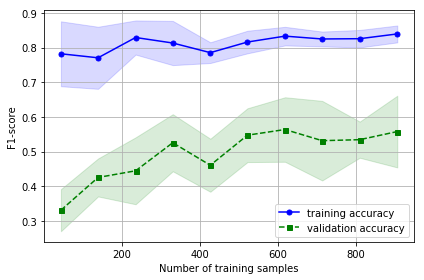

In [15]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(estimator=bestbg,
                               X=X,
                               y=Y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=1,
                               scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

In [16]:
bg = bestbg.fit(X_trainpca, y_trainpca)
bg.score(X_testpca,y_testpca)

0.7251655629139073

In [17]:
cvs = cv.cross_val_score(Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(), random_state=0),
                         X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.7685714285714286

In [18]:
pred=bg.predict(X_testpca)

print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[ 16   7   0   0   0]
 [ 22 161  17   0   0]
 [  0  24  37   1   0]
 [  0   0   7   5   0]
 [  0   0   1   4   0]]
0.7251655629139073
              precision    recall  f1-score   support

           0       0.42      0.70      0.52        23
           1       0.84      0.81      0.82       200
           2       0.60      0.60      0.60        62
           3       0.50      0.42      0.45        12
           4       0.00      0.00      0.00         5

    accuracy                           0.73       302
   macro avg       0.47      0.50      0.48       302
weighted avg       0.73      0.73      0.72       302



## Random Forests

In [19]:
rfc = Ens.RandomForestClassifier().fit(X_train, y_train)
rfc.score(X_test,y_test)

0.847682119205298

In [20]:
cvs = cv.cross_val_score(Ens.RandomForestClassifier(),X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.8181287726358148

In [21]:
pred=rfc.predict(X_test)
print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 12  11   0   0   0]
 [  2 191   7   0   0]
 [  0  18  44   0   0]
 [  0   0   5   7   0]
 [  0   0   0   3   2]]
0.847682119205298
              precision    recall  f1-score   support

           0       0.86      0.52      0.65        23
           1       0.87      0.95      0.91       200
           2       0.79      0.71      0.75        62
           3       0.70      0.58      0.64        12
           4       1.00      0.40      0.57         5

    accuracy                           0.85       302
   macro avg       0.84      0.63      0.70       302
weighted avg       0.85      0.85      0.84       302



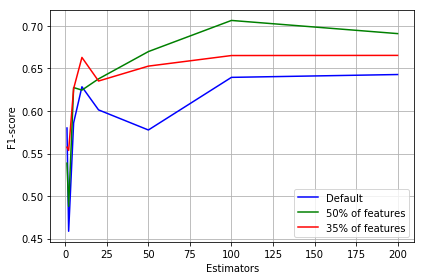

In [22]:
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest, max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest, max_features=0.5),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Default')
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='50% of features')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='35% of features')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

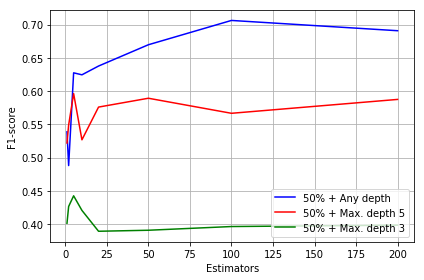

In [23]:
plt.plot([1,2,5,10,20,50,100,200],lb3,'b',label='50% + Any depth')

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest,
                                                           max_features=0.50,
                                                           max_depth=3),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest,
                                                           max_features=0.50,
                                                           max_depth=5),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())
    
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='50% + Max. depth 5')
plt.plot([1,2,5,10,20,50,100,200],lb,'g',label='50% + Max. depth 3')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

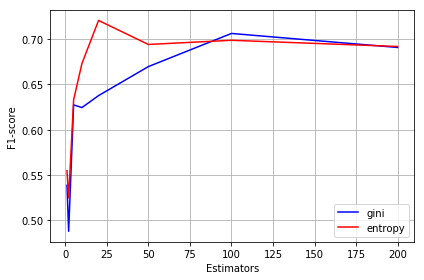

In [24]:
lb=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.RandomForestClassifier(n_estimators=nest,
                                                           criterion='entropy',
                                                           max_features=0.5),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())
    
plt.plot([1,2,5,10,20,50,100,200],lb3,'b',label='gini')
plt.plot([1,2,5,10,20,50,100,200],lb,'r',label='entropy')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

In [25]:
bestrf = Ens.RandomForestClassifier(n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb)],
                                    criterion='entropy',
                                    max_features=0.5)

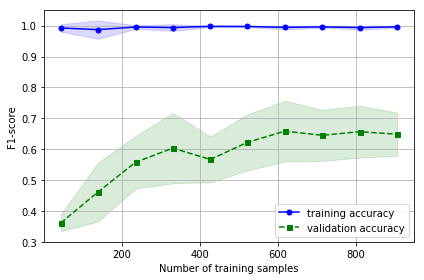

In [26]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(bestrf,
                               X=X,
                               y=Y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=1,
                               scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

In [27]:
rfc = bestrf
rfc = rfc.fit(X, Y)
print(rfc.feature_importances_)  

[1.29498704e-02 3.26284659e-03 5.05465295e-02 2.13124284e-03
 5.74906600e-03 3.51835945e-03 2.07174121e-02 2.35071069e-03
 2.21516571e-03 4.07728146e-03 1.83920336e-01 5.17651763e-02
 8.67296591e-03 1.41070017e-04 1.41357260e-02 4.41042638e-02
 2.66006813e-03 1.62833947e-02 2.08767383e-03 7.16345815e-03
 1.31250027e-01 7.00885877e-03 1.99818349e-02 1.89818882e-01
 5.18192954e-03 8.94317889e-04 2.17019931e-02 1.72521968e-02
 6.10072932e-04 9.41494157e-03 9.03846204e-03 6.31857548e-03
 7.50195270e-03 6.60879306e-02 1.92664941e-03 3.98902745e-03
 2.21623626e-03 1.09636032e-03 1.28662838e-03 5.35709857e-03
 1.56154513e-02 2.34707070e-03 2.21043784e-03 3.12859223e-02
 2.15452354e-03 0.00000000e+00]


In [28]:
model = feat.SelectFromModel(rfc, prefit=True, threshold=0.05)
X_new = model.transform(X)
print(X_new.shape)

print(np.mean(cv.cross_val_score(rfc, X=X, y=Y, cv=kfold, scoring='f1_macro')))
print(np.mean(cv.cross_val_score(rfc, X=X_new, y=Y, cv=kfold, scoring='f1_macro')))

(1006, 6)
0.6960057783247731
0.6384197348386073


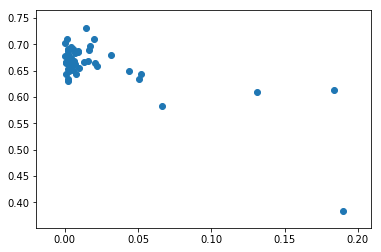

Best threshold:  0.01413572601888696


In [29]:
thresholds=rfc.feature_importances_

l=[]
for threshold in thresholds:
    model = feat.SelectFromModel(rfc, prefit=True, threshold=threshold)
    X_new = model.transform(X)
    acc = np.mean(cv.cross_val_score(rfc, X=X_new, y=Y, cv=kfold, scoring='f1_macro'))
    l.append(acc)
    
plt.scatter(thresholds,l)
plt.show()

print('Best threshold: ',thresholds[np.argmax(l)])

In [30]:
model = feat.SelectFromModel(rfc, prefit=True, threshold=thresholds[np.argmax(l)])
X_new = model.transform(X)

In [31]:
X_train2, X_test2, y_train2, y_test2 = cv.train_test_split(X_new, Y, test_size=.3, random_state=1)

In [32]:
rfc = bestrf.fit(X_train2, y_train2)
rfc.score(X_test2,y_test2)

0.8543046357615894

In [33]:
cvs = cv.cross_val_score(bestrf,X=X_train2,y=y_train2,cv=kfold)
np.mean(cvs)

0.8252515090543259

In [34]:
pred=rfc.predict(X_test2)
print(m.confusion_matrix(y_test2, pred))
print(m.accuracy_score(y_test2, pred))
print(m.classification_report(y_test2, pred))

[[ 12  11   0   0   0]
 [  3 188   9   0   0]
 [  0  12  49   1   0]
 [  0   0   5   7   0]
 [  0   0   1   2   2]]
0.8543046357615894
              precision    recall  f1-score   support

           0       0.80      0.52      0.63        23
           1       0.89      0.94      0.91       200
           2       0.77      0.79      0.78        62
           3       0.70      0.58      0.64        12
           4       1.00      0.40      0.57         5

    accuracy                           0.85       302
   macro avg       0.83      0.65      0.71       302
weighted avg       0.85      0.85      0.85       302



In [35]:
rfc = bestrf.fit(X_trainpca, y_trainpca)
rfc.score(X_testpca,y_testpca)

0.7980132450331126

In [36]:
cvs = cv.cross_val_score(bestrf,X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.7826961770623743

In [37]:
pred=rfc.predict(X_testpca)
print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[ 12  11   0   0   0]
 [  4 173  23   0   0]
 [  0  14  45   3   0]
 [  0   0   2   9   1]
 [  0   0   0   3   2]]
0.7980132450331126
              precision    recall  f1-score   support

           0       0.75      0.52      0.62        23
           1       0.87      0.86      0.87       200
           2       0.64      0.73      0.68        62
           3       0.60      0.75      0.67        12
           4       0.67      0.40      0.50         5

    accuracy                           0.80       302
   macro avg       0.71      0.65      0.67       302
weighted avg       0.80      0.80      0.80       302



## Extra Trees


In [38]:
etc = Ens.ExtraTreesClassifier().fit(X_train, y_train)
etc.score(X_test,y_test)

0.8443708609271523

In [39]:
cvs = cv.cross_val_score(Ens.ExtraTreesClassifier(),X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.7953923541247485

In [40]:
pred = etc.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 11  12   0   0   0]
 [  3 192   5   0   0]
 [  0  20  41   1   0]
 [  0   0   2   9   1]
 [  0   0   0   3   2]]
0.8443708609271523
              precision    recall  f1-score   support

           0       0.79      0.48      0.59        23
           1       0.86      0.96      0.91       200
           2       0.85      0.66      0.75        62
           3       0.69      0.75      0.72        12
           4       0.67      0.40      0.50         5

    accuracy                           0.84       302
   macro avg       0.77      0.65      0.69       302
weighted avg       0.84      0.84      0.83       302



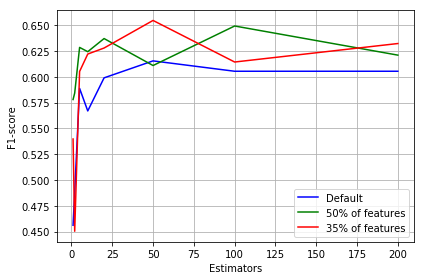

In [41]:
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest,
                                                         max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest,
                                                           max_features=0.5),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Default')
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='50% of features')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='35% of features')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

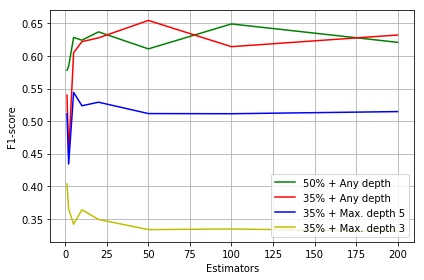

In [42]:
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='50% + Any depth')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='35% + Any depth')

lb=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest,
                                                         max_depth=3,
                                                         max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb4=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest,
                                                         max_depth=5,
                                                         max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb4.append(scores.mean())

    
plt.plot([1,2,5,10,20,50,100,200],lb4,'b',label='35% + Max. depth 5')
plt.plot([1,2,5,10,20,50,100,200],lb,'y',label='35% + Max. depth 3')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

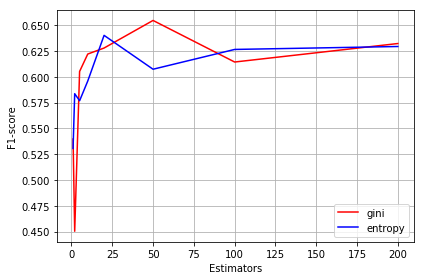

In [43]:
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='gini')
lb5=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.ExtraTreesClassifier(n_estimators=nest,
                                                           criterion='entropy',
                                                           max_features=0.35),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb5.append(scores.mean())
    
plt.plot([1,2,5,10,20,50,100,200],lb5,'b',label='entropy')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

In [44]:
bestet = Ens.ExtraTreesClassifier(n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb2)],
                                    max_features=0.35)

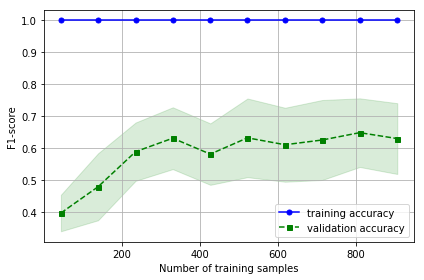

In [45]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(estimator=bestet,
                                  X=X,
                                  y=Y,
                                  train_sizes=np.linspace(0.05, 1.0, 10),
                                  cv=10,
                                  n_jobs=1,
                                  scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

In [46]:
etc = bestet.fit(X_trainpca, y_trainpca)
etc.score(X_testpca,y_testpca)

0.7781456953642384

In [47]:
cvs = cv.cross_val_score(bestet,X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.757102615694165

In [48]:
pred = etc.predict(X_testpca)

print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[ 12  11   0   0   0]
 [  6 172  22   0   0]
 [  0  18  41   3   0]
 [  0   1   1   8   2]
 [  0   0   0   3   2]]
0.7781456953642384
              precision    recall  f1-score   support

           0       0.67      0.52      0.59        23
           1       0.85      0.86      0.86       200
           2       0.64      0.66      0.65        62
           3       0.57      0.67      0.62        12
           4       0.50      0.40      0.44         5

    accuracy                           0.78       302
   macro avg       0.65      0.62      0.63       302
weighted avg       0.78      0.78      0.78       302



## AdaBoost

In [49]:
adb = Ens.AdaBoostClassifier().fit(X_train, y_train)
adb.score(X_test,y_test)

0.4900662251655629

In [50]:
cvs = cv.cross_val_score(Ens.AdaBoostClassifier(),X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.5498390342052314

In [51]:
pred = adb.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[17  6  0  0  0]
 [71 85 44  0  0]
 [ 6 10 46  0  0]
 [ 0  0 12  0  0]
 [ 0  0  5  0  0]]
0.4900662251655629
              precision    recall  f1-score   support

           0       0.18      0.74      0.29        23
           1       0.84      0.42      0.56       200
           2       0.43      0.74      0.54        62
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         5

    accuracy                           0.49       302
   macro avg       0.29      0.38      0.28       302
weighted avg       0.66      0.49      0.51       302



In [52]:
adb = Ens.AdaBoostClassifier(base_estimator=Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(max_depth=1),
                                                             random_state=0)).fit(X_train, y_train)
adb.score(X_test,y_test)

0.7384105960264901

In [53]:
cvs = cv.cross_val_score(Ens.AdaBoostClassifier(base_estimator=
                                                Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(max_depth=1),
                                                                                     random_state=0)),
                         X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.7132997987927565

In [54]:
pred = adb.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 12  10   1   0   0]
 [ 20 150  30   0   0]
 [  0   4  58   0   0]
 [  0   0   9   3   0]
 [  0   0   1   4   0]]
0.7384105960264901
              precision    recall  f1-score   support

           0       0.38      0.52      0.44        23
           1       0.91      0.75      0.82       200
           2       0.59      0.94      0.72        62
           3       0.43      0.25      0.32        12
           4       0.00      0.00      0.00         5

    accuracy                           0.74       302
   macro avg       0.46      0.49      0.46       302
weighted avg       0.77      0.74      0.74       302



In [55]:
adb = Ens.AdaBoostClassifier(base_estimator=Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                                                             random_state=0)).fit(X_train, y_train)
adb.score(X_test,y_test)

0.8642384105960265

In [56]:
cvs = cv.cross_val_score(Ens.AdaBoostClassifier(base_estimator=
                                                Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(),
                                                                      random_state=0)),
                         X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.8111066398390342

In [57]:
pred = adb.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 12  11   0   0   0]
 [  2 187  11   0   0]
 [  0   7  55   0   0]
 [  0   0   6   6   0]
 [  0   0   0   4   1]]
0.8642384105960265
              precision    recall  f1-score   support

           0       0.86      0.52      0.65        23
           1       0.91      0.94      0.92       200
           2       0.76      0.89      0.82        62
           3       0.60      0.50      0.55        12
           4       1.00      0.20      0.33         5

    accuracy                           0.86       302
   macro avg       0.83      0.61      0.65       302
weighted avg       0.87      0.86      0.86       302



In [58]:
adb = Ens.AdaBoostClassifier(Ens.RandomForestClassifier()).fit(X_train, y_train)
adb.score(X_test,y_test)

0.8543046357615894

In [59]:
cvs = cv.cross_val_score(Ens.AdaBoostClassifier(Ens.RandomForestClassifier()),X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.8067806841046277

In [60]:
pred = adb.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 11  12   0   0   0]
 [  3 194   3   0   0]
 [  0  16  45   1   0]
 [  0   0   5   7   0]
 [  0   0   0   4   1]]
0.8543046357615894
              precision    recall  f1-score   support

           0       0.79      0.48      0.59        23
           1       0.87      0.97      0.92       200
           2       0.85      0.73      0.78        62
           3       0.58      0.58      0.58        12
           4       1.00      0.20      0.33         5

    accuracy                           0.85       302
   macro avg       0.82      0.59      0.64       302
weighted avg       0.85      0.85      0.84       302



In [61]:
adb = Ens.AdaBoostClassifier(Ens.ExtraTreesClassifier()).fit(X_train, y_train)
adb.score(X_test,y_test)

0.8509933774834437

In [62]:
cvs = cv.cross_val_score(Ens.AdaBoostClassifier(Ens.ExtraTreesClassifier()),X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.7954124748490946

In [63]:
pred = adb.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 13  10   0   0   0]
 [  2 190   8   0   0]
 [  0  18  44   0   0]
 [  0   0   3   8   1]
 [  0   0   0   3   2]]
0.8509933774834437
              precision    recall  f1-score   support

           0       0.87      0.57      0.68        23
           1       0.87      0.95      0.91       200
           2       0.80      0.71      0.75        62
           3       0.73      0.67      0.70        12
           4       0.67      0.40      0.50         5

    accuracy                           0.85       302
   macro avg       0.79      0.66      0.71       302
weighted avg       0.85      0.85      0.84       302



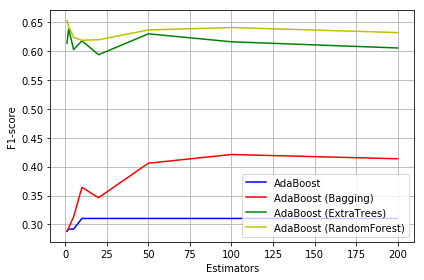

In [64]:
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.AdaBoostClassifier(n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.AdaBoostClassifier(n_estimators=nest,
                                                       base_estimator=Ens.BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(max_depth=1),
                                                                                            random_state=0)),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.AdaBoostClassifier(n_estimators=nest,
                                                       base_estimator=Ens.ExtraTreesClassifier()),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

lb4=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.AdaBoostClassifier(n_estimators=nest,
                                                       base_estimator=Ens.RandomForestClassifier()),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb4.append(scores.mean())
    
    
    
plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='AdaBoost')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='AdaBoost (Bagging)')
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='AdaBoost (ExtraTrees)')
plt.plot([1,2,5,10,20,50,100,200],lb4,'y',label='AdaBoost (RandomForest)')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

In [65]:
bestab = Ens.AdaBoostClassifier(n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb)])
bestab2 = Ens.AdaBoostClassifier(n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb4)],
                                                       base_estimator=Ens.RandomForestClassifier())

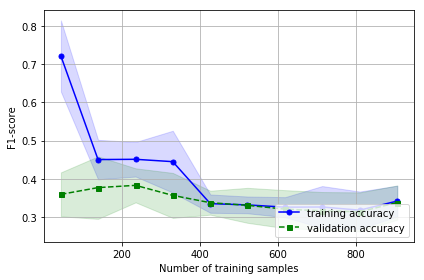

In [66]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(estimator=bestab,
                               X=X,
                               y=Y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1,
                               scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

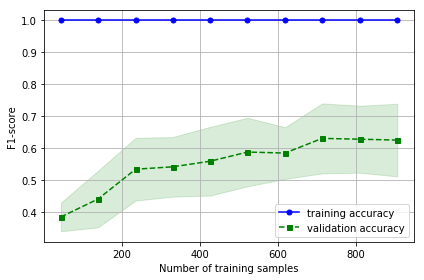

In [67]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(estimator=bestab2,
                               X=X,
                               y=Y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1,
                               scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

In [68]:
adb = bestab.fit(X_trainpca, y_trainpca)
adb.score(X_testpca,y_testpca)

0.6324503311258278

In [69]:
cvs = cv.cross_val_score(bestab,X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.6251106639839035

In [70]:
pred = adb.predict(X_testpca)

print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[  3  20   0   0   0]
 [  6 148  46   0   0]
 [  0  22  40   0   0]
 [  0   0  12   0   0]
 [  0   0   5   0   0]]
0.6324503311258278
              precision    recall  f1-score   support

           0       0.33      0.13      0.19        23
           1       0.78      0.74      0.76       200
           2       0.39      0.65      0.48        62
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         5

    accuracy                           0.63       302
   macro avg       0.30      0.30      0.29       302
weighted avg       0.62      0.63      0.62       302



In [71]:
adb = bestab2.fit(X_trainpca, y_trainpca)
adb.score(X_testpca,y_testpca)

0.7947019867549668

In [72]:
cvs = cv.cross_val_score(bestab2,X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.7741046277665997

In [73]:
pred = adb.predict(X_testpca)

print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[ 11  12   0   0   0]
 [  3 178  19   0   0]
 [  0  17  42   3   0]
 [  0   0   4   7   1]
 [  0   0   0   3   2]]
0.7947019867549668
              precision    recall  f1-score   support

           0       0.79      0.48      0.59        23
           1       0.86      0.89      0.87       200
           2       0.65      0.68      0.66        62
           3       0.54      0.58      0.56        12
           4       0.67      0.40      0.50         5

    accuracy                           0.79       302
   macro avg       0.70      0.61      0.64       302
weighted avg       0.79      0.79      0.79       302



## Gradient Tree Boosting

In [74]:
gbc = Ens.GradientBoostingClassifier().fit(X_train, y_train)
gbc.score(X_test,y_test)

0.847682119205298

In [75]:
cvs = cv.cross_val_score(gbc,X=X_train,y=y_train,cv=kfold)
np.mean(cvs)

0.8109255533199194

In [76]:
pred = gbc.predict(X_test)

print(m.confusion_matrix(y_test, pred))
print(m.accuracy_score(y_test, pred))
print(m.classification_report(y_test, pred))

[[ 11  12   0   0   0]
 [  2 188  10   0   0]
 [  0  14  47   1   0]
 [  0   0   5   7   0]
 [  0   0   1   1   3]]
0.847682119205298
              precision    recall  f1-score   support

           0       0.85      0.48      0.61        23
           1       0.88      0.94      0.91       200
           2       0.75      0.76      0.75        62
           3       0.78      0.58      0.67        12
           4       1.00      0.60      0.75         5

    accuracy                           0.85       302
   macro avg       0.85      0.67      0.74       302
weighted avg       0.85      0.85      0.84       302



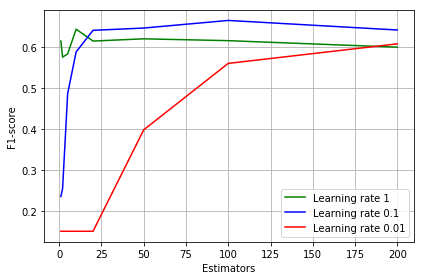

In [77]:
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb.append(scores.mean())

lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=0.01),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=1),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='Learning rate 1')
plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Learning rate 0.1')
plt.plot([1,2,5,10,20,50,100,200],lb2,'r',label='Learning rate 0.01')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

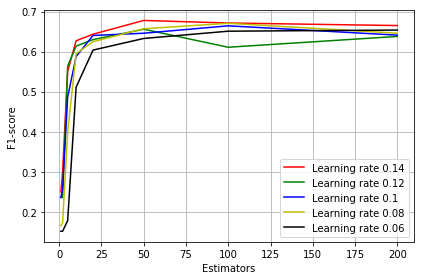

In [78]:
lb2=[]   
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=0.08),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb2.append(scores.mean())

lb4=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=0.06),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb4.append(scores.mean())

lb3=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=0.12),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb3.append(scores.mean())

lb5=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cv.cross_val_score(Ens.GradientBoostingClassifier(n_estimators=nest, learning_rate=0.14),
                                X_train, y_train, cv=kfold, scoring='f1_macro')
    lb5.append(scores.mean())

    
plt.plot([1,2,5,10,20,50,100,200],lb5,'r',label='Learning rate 0.14')
plt.plot([1,2,5,10,20,50,100,200],lb3,'g',label='Learning rate 0.12')
plt.plot([1,2,5,10,20,50,100,200],lb,'b',label='Learning rate 0.1')
plt.plot([1,2,5,10,20,50,100,200],lb2,'y',label='Learning rate 0.08')
plt.plot([1,2,5,10,20,50,100,200],lb4,'black',label='Learning rate 0.06')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.show()

In [80]:
bestgb = Ens.GradientBoostingClassifier(learning_rate=0.14, n_estimators=[1,2,5,10,20,50,100,200][np.argmax(lb5)])

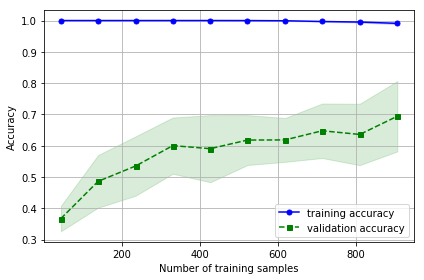

In [81]:
train_sizes, train_scores, test_scores =\
                cv.learning_curve(estimator=bestgb,
                               X=X,
                               y=Y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=1,
                               scoring='f1_macro')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

In [82]:
gbc = bestgb.fit(X_trainpca, y_trainpca)
gbc.score(X_testpca,y_testpca)


0.8013245033112583

In [83]:
cvs = cv.cross_val_score(gbc,X=X_trainpca,y=y_trainpca,cv=kfold)
np.mean(cvs)

0.7713480885311872

In [84]:
pred = gbc.predict(X_testpca)

print(m.confusion_matrix(y_testpca, pred))
print(m.accuracy_score(y_testpca, pred))
print(m.classification_report(y_testpca, pred))

[[ 11  12   0   0   0]
 [  3 177  20   0   0]
 [  0  14  44   4   0]
 [  0   0   3   8   1]
 [  0   0   1   2   2]]
0.8013245033112583
              precision    recall  f1-score   support

           0       0.79      0.48      0.59        23
           1       0.87      0.89      0.88       200
           2       0.65      0.71      0.68        62
           3       0.57      0.67      0.62        12
           4       0.67      0.40      0.50         5

    accuracy                           0.80       302
   macro avg       0.71      0.63      0.65       302
weighted avg       0.80      0.80      0.80       302



## Voting scheme

In [85]:
#import sklearn.neighbors as N

#knc = N.KNeighborsClassifier()
#sorted(N.VALID_METRICS['brute'])

from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

cvp=50

clf1 = GaussianNB()

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=cvp,n_jobs=-1,scoring='f1_macro')  # If cvp is integer, by default is Stratifyed 
clf.fit(X, Y)
print("Best Params fo Knn=",clf.best_params_, "F1-score=", clf.best_score_)
parval=clf.best_params_
clf2 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])

clf3 = DecisionTreeClassifier(criterion='entropy')


for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(clf, X, Y, cv=cvp, scoring='f1_macro')
    print("F1-score: %0.3f [%s]" % (scores.mean(), label))

Best Params fo Knn= {'n_neighbors': 5, 'weights': 'uniform'} F1-score= 0.4791471079694918
F1-score: 0.233 [Naive Bayes]
F1-score: 0.479 [Knn (3)]
F1-score: 0.544 [Dec. Tree]


In [86]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)], voting='hard')
scores = cross_val_score(eclf, X, Y, cv=cvp, scoring='f1_macro')
print("F1-score: %0.3f [%s]" % (scores.mean() , "Majority Voting"))

F1-score: 0.511 [Majority Voting]


In [87]:
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[1,5,10])
scores = cross_val_score(eclf, X, Y, cv=cvp, scoring='f1_macro')
print("F1-score: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

F1-score: 0.553 [Weighted Voting]


In [88]:
bestvc = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[1,5,10])

## Comparison of the best models

In [93]:
import statsmodels.stats.proportion as Prop

test_data = pd.read_csv('../datasets/preprocessed/test.csv', sep=',')
X_test = test_data.drop(columns=['Id','SalePrice'])
y_test = test_data['SalePrice']

le = Pre.LabelEncoder()
le.fit(y_test)
y_test = le.fit_transform(y_test)
i = 0
for t in X_test.dtypes:
    if t == object or t == bool:
        le.fit(X_test.iloc[:,i])
        X_test.iloc[:,i] = le.fit_transform(X_test.iloc[:,i])
    i += 1

print('                    F1      Conf Int    Acc   Prec    Rec')
pred = bestbg.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('Bagging:         %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestrf.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('Random Forests:  %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestet.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('Extra Trees:     %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestab.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('AdaBoost:        %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestab2.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('AdaBoost (RF):   %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestgb.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('Gradient Boost:  %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))
pred = bestvc.fit(X_train, y_train).predict(X_test)
pro1, pro2 = Prop.proportion_confint(count=m.f1_score(y_test, pred, average='macro')*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')
print('Voting Scheme:   %0.3f (%0.3f,%0.3f)  %0.3f  %0.3f  %0.3f ' %  (m.f1_score(y_test, pred, average='macro'),
                                                                       pro1,
                                                                       pro2,
                                                                       m.accuracy_score(y_test, pred),
                                                                       m.precision_score(y_test, pred, average='macro'),
                                                                       m.recall_score(y_test, pred, average='macro')))

                    F1      Conf Int    Acc   Prec    Rec
Bagging:         0.583 (0.534,0.627)  0.755  0.625  0.568 
Random Forests:  0.662 (0.616,0.706)  0.831  0.770  0.612 
Extra Trees:     0.674 (0.627,0.717)  0.845  0.834  0.608 
AdaBoost:        0.288 (0.245,0.332)  0.500  0.296  0.376 
AdaBoost (RF):   0.673 (0.625,0.714)  0.845  0.857  0.606 
Gradient Boost:  0.681 (0.634,0.724)  0.838  0.804  0.635 
Voting Scheme:   0.587 (0.538,0.632)  0.769  0.594  0.586 
